# 0. 프로젝트 정의하기!

주거 공간의 면적, 위치, 경관, 건물의 연식 등의 데이터로 집의 가격을 예측하는 프로젝트이다.  
어떤 조건을 가진 집의 가격이 높고 낮은지를 예측하는 모델을 만드는 것을 목표로 한다.

https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr

# 1. 데이터 확인하기!

In [12]:
import os
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

In [13]:
data_dir = os.getenv('USERPROFILE')+'\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\\3\data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

C:\Users\Hugh\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\3\data\train.csv
C:\Users\Hugh\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\3\data\test.csv


In [14]:
origin_train = pd.read_csv(train_data_path)
origin_test_X = pd.read_csv(sub_data_path)
train = origin_train.copy()
test_X = origin_test_X.copy()
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test_X.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


<AxesSubplot:>

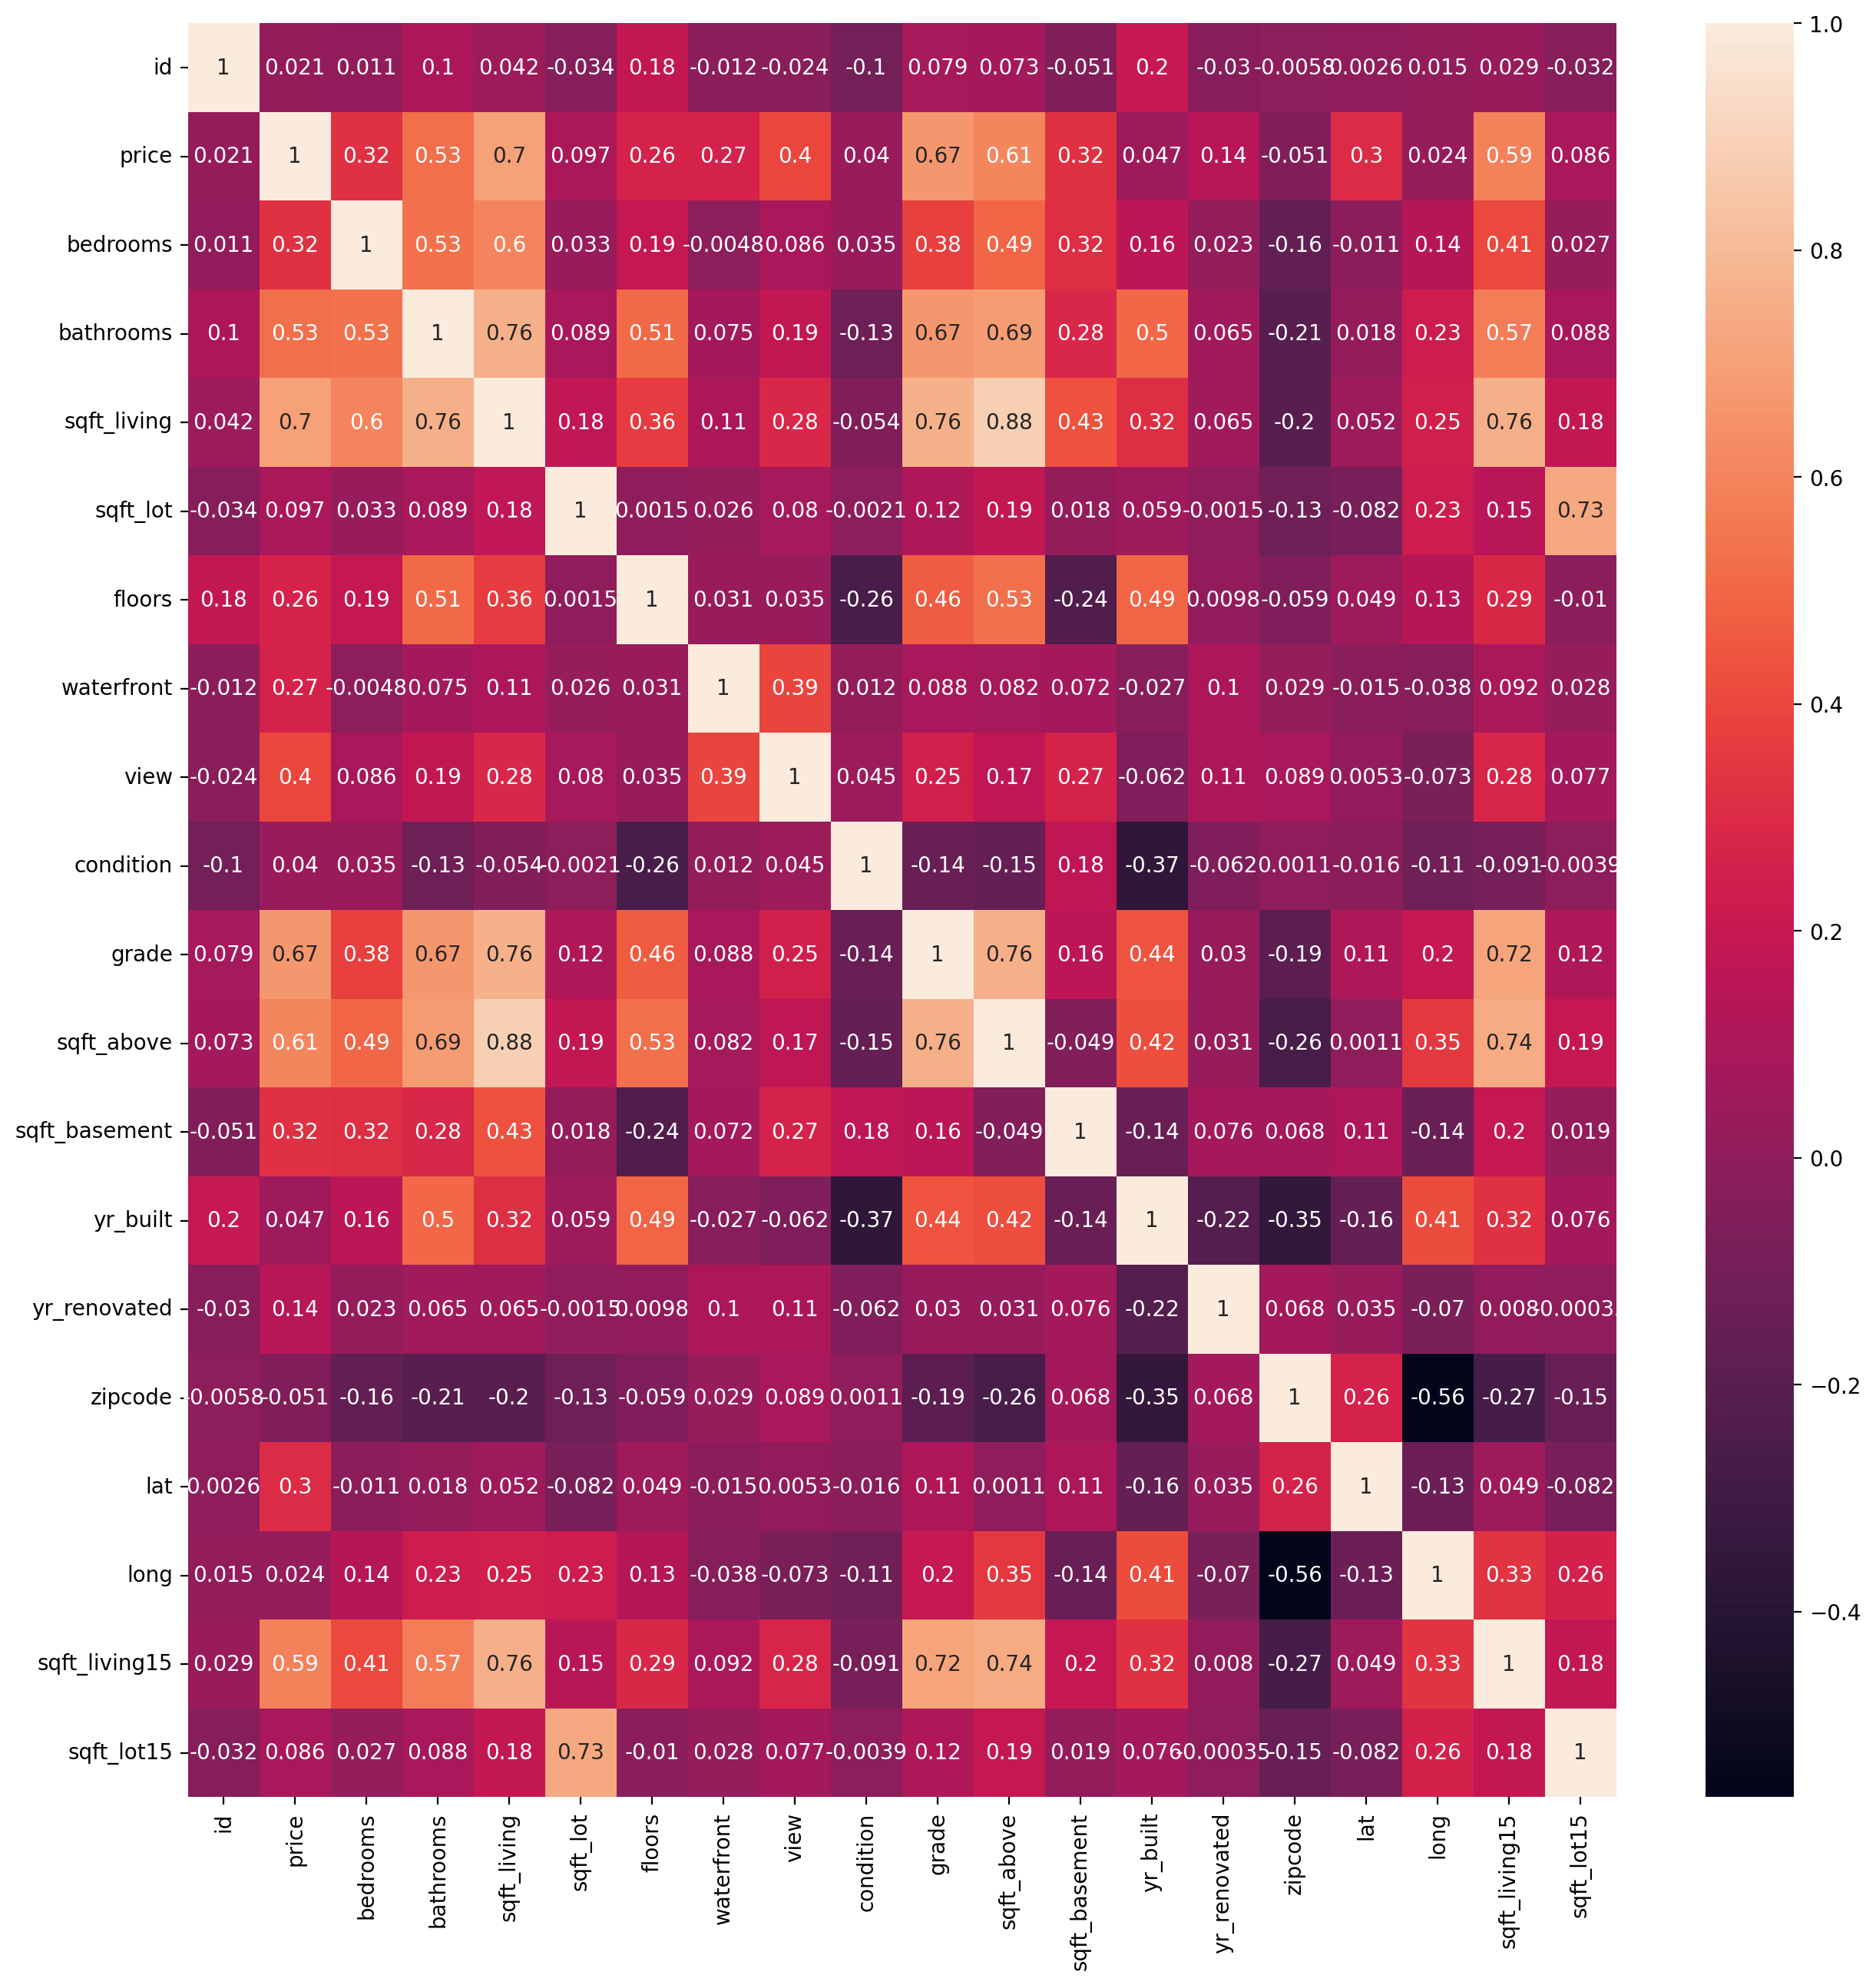

In [15]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True)

데이터 정보
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

# 2. train, test 데이터 합치기!

전체 자료의 특징을 한 번에 살펴보기 위해 데이터를 합친다.

In [16]:
train_y = train['price']
print(train_y.head())

print(train.shape)
train_X = train.drop('price', axis=1)
print(train_X.shape)

0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64
(15035, 21)
(15035, 20)


In [17]:
origin_whole_X = pd.concat((train_X, test_X), axis=0)
whole_X = origin_whole_X.copy()

whole_X.shape

(21503, 20)

In [18]:
whole_X.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [19]:
whole_X.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,10751.000000,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,6207.525755,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5375.500000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,10751.000000,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,16126.500000,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,21502.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [20]:
for column in whole_X.columns:
    print('{} : {}'.format(column, pd.isnull(whole_X[column]).sum()))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


# 3. 데이터 전처리하기!

## 3.1 필요없는 열 제거하기!

In [21]:
print(whole_X.shape)
whole_X.drop('id', axis=1, inplace=True)
print(whole_X.shape)

(21503, 20)
(21503, 19)


## 3.2 시계열 년월일로 나누기!

In [22]:
whole_X['date'].apply(lambda x: x[8:]).value_counts()

T000000    21503
Name: date, dtype: int64

In [23]:
whole_X['date'] = whole_X['date'].apply(lambda x: (x[:4], x[4:6], x[6:8])).apply(lambda x: '-'.join(x))
whole_X['date'] = pd.to_datetime(whole_X['date'])
whole_X['date'].head()

0   2014-10-13
1   2015-02-25
2   2015-02-18
3   2014-06-27
4   2015-01-15
Name: date, dtype: datetime64[ns]

In [24]:
whole_X['year'] = whole_X['date'].dt.year
whole_X['month'] = whole_X['date'].dt.month
whole_X['day'] = whole_X['date'].dt.day
print(whole_X.iloc[:,-3:])

      year  month  day
0     2014     10   13
1     2015      2   25
2     2015      2   18
3     2014      6   27
4     2015      1   15
...    ...    ...  ...
6463  2014      6   26
6464  2015      1   26
6465  2015      2   19
6466  2014      6   23
6467  2015      1   16

[21503 rows x 3 columns]


In [25]:
print(whole_X.shape)
whole_X.drop('date', axis=1, inplace=True)
print(whole_X.shape)

(21503, 22)
(21503, 21)


In [26]:
for column in whole_X.columns:
    print(whole_X[column].value_counts(), end='\n\n')

3     9764
4     6860
2     2746
5     1592
6      271
1      195
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

2.50    5364
1.00    3820
1.75    3029
2.25    2034
2.00    1921
1.50    1438
2.75    1183
3.00     750
3.50     729
3.25     586
3.75     155
4.00     135
4.50      99
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

1300    136
1400    134
1440    133
1660    128
1800    128
       ... 
3133      1
5210      1
2905      1
2717      1
3118      1
Name: sqft_living, Length: 1038, dtype: int64

5000     357
6000     288
4000     250
7200     219
7500     119
        ... 
6086       1
8515       1
12096      1
12786      1
2388       1
Name: sqft_lot, Length: 9782, dtype: int64

1.0    10612
2.0     8216
1.5     1895
3

## 3.3 데이터 시각화하기!

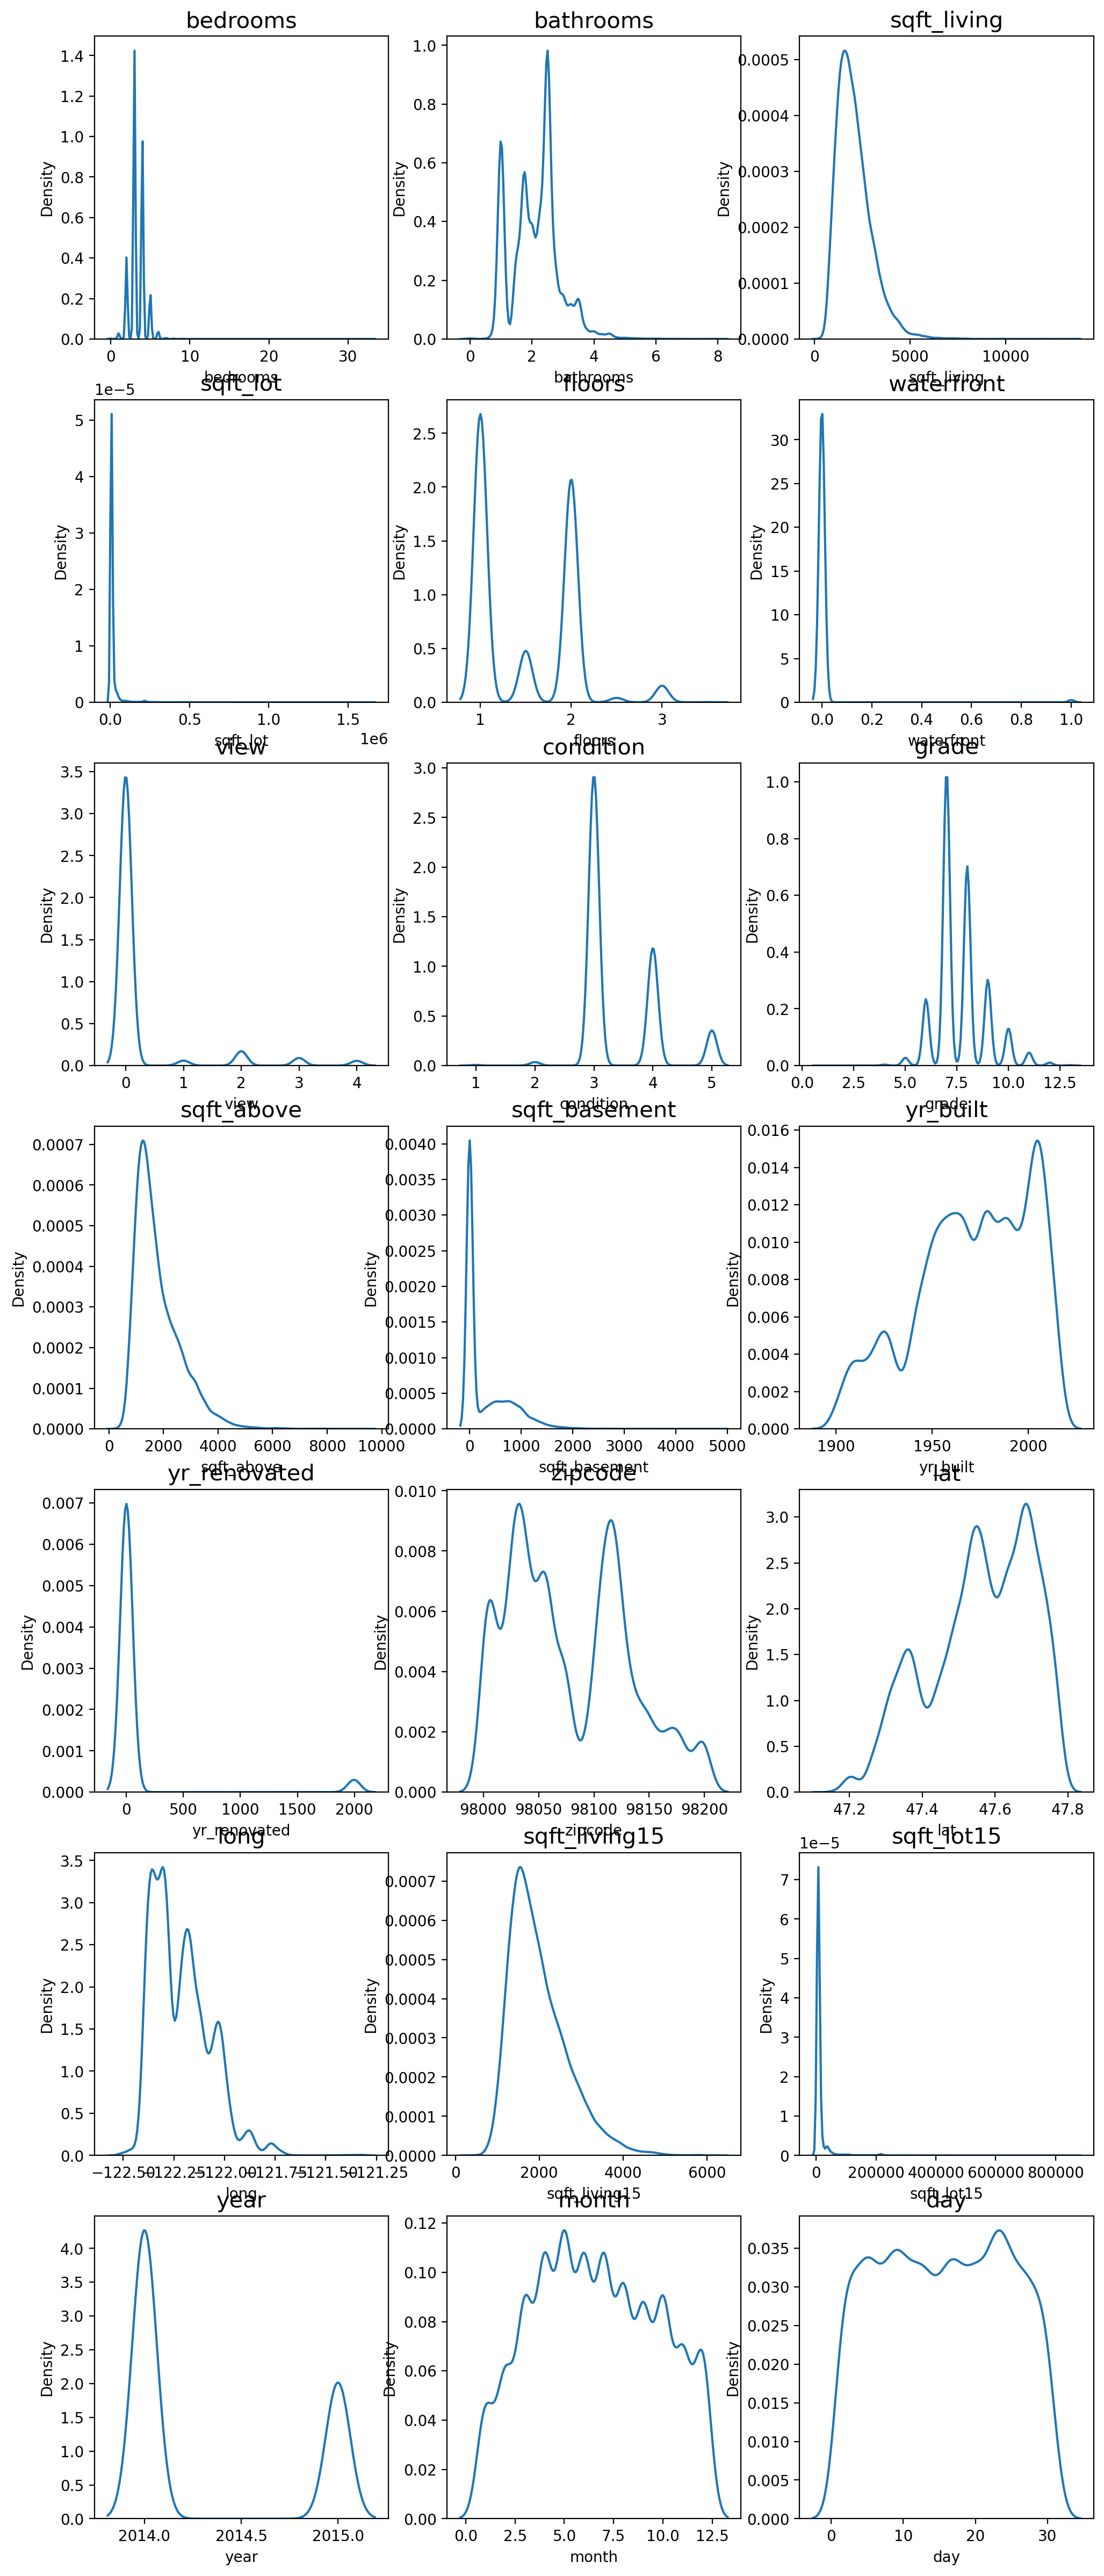

In [27]:
fig, ax = plt.subplots(7, 3, figsize=(12, 30))

columns = whole_X.columns
count = 0
for row in range(7):
    for col in range(3):
        sns.kdeplot(data=whole_X[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == whole_X.shape[1]:
            break
            
plt.show()

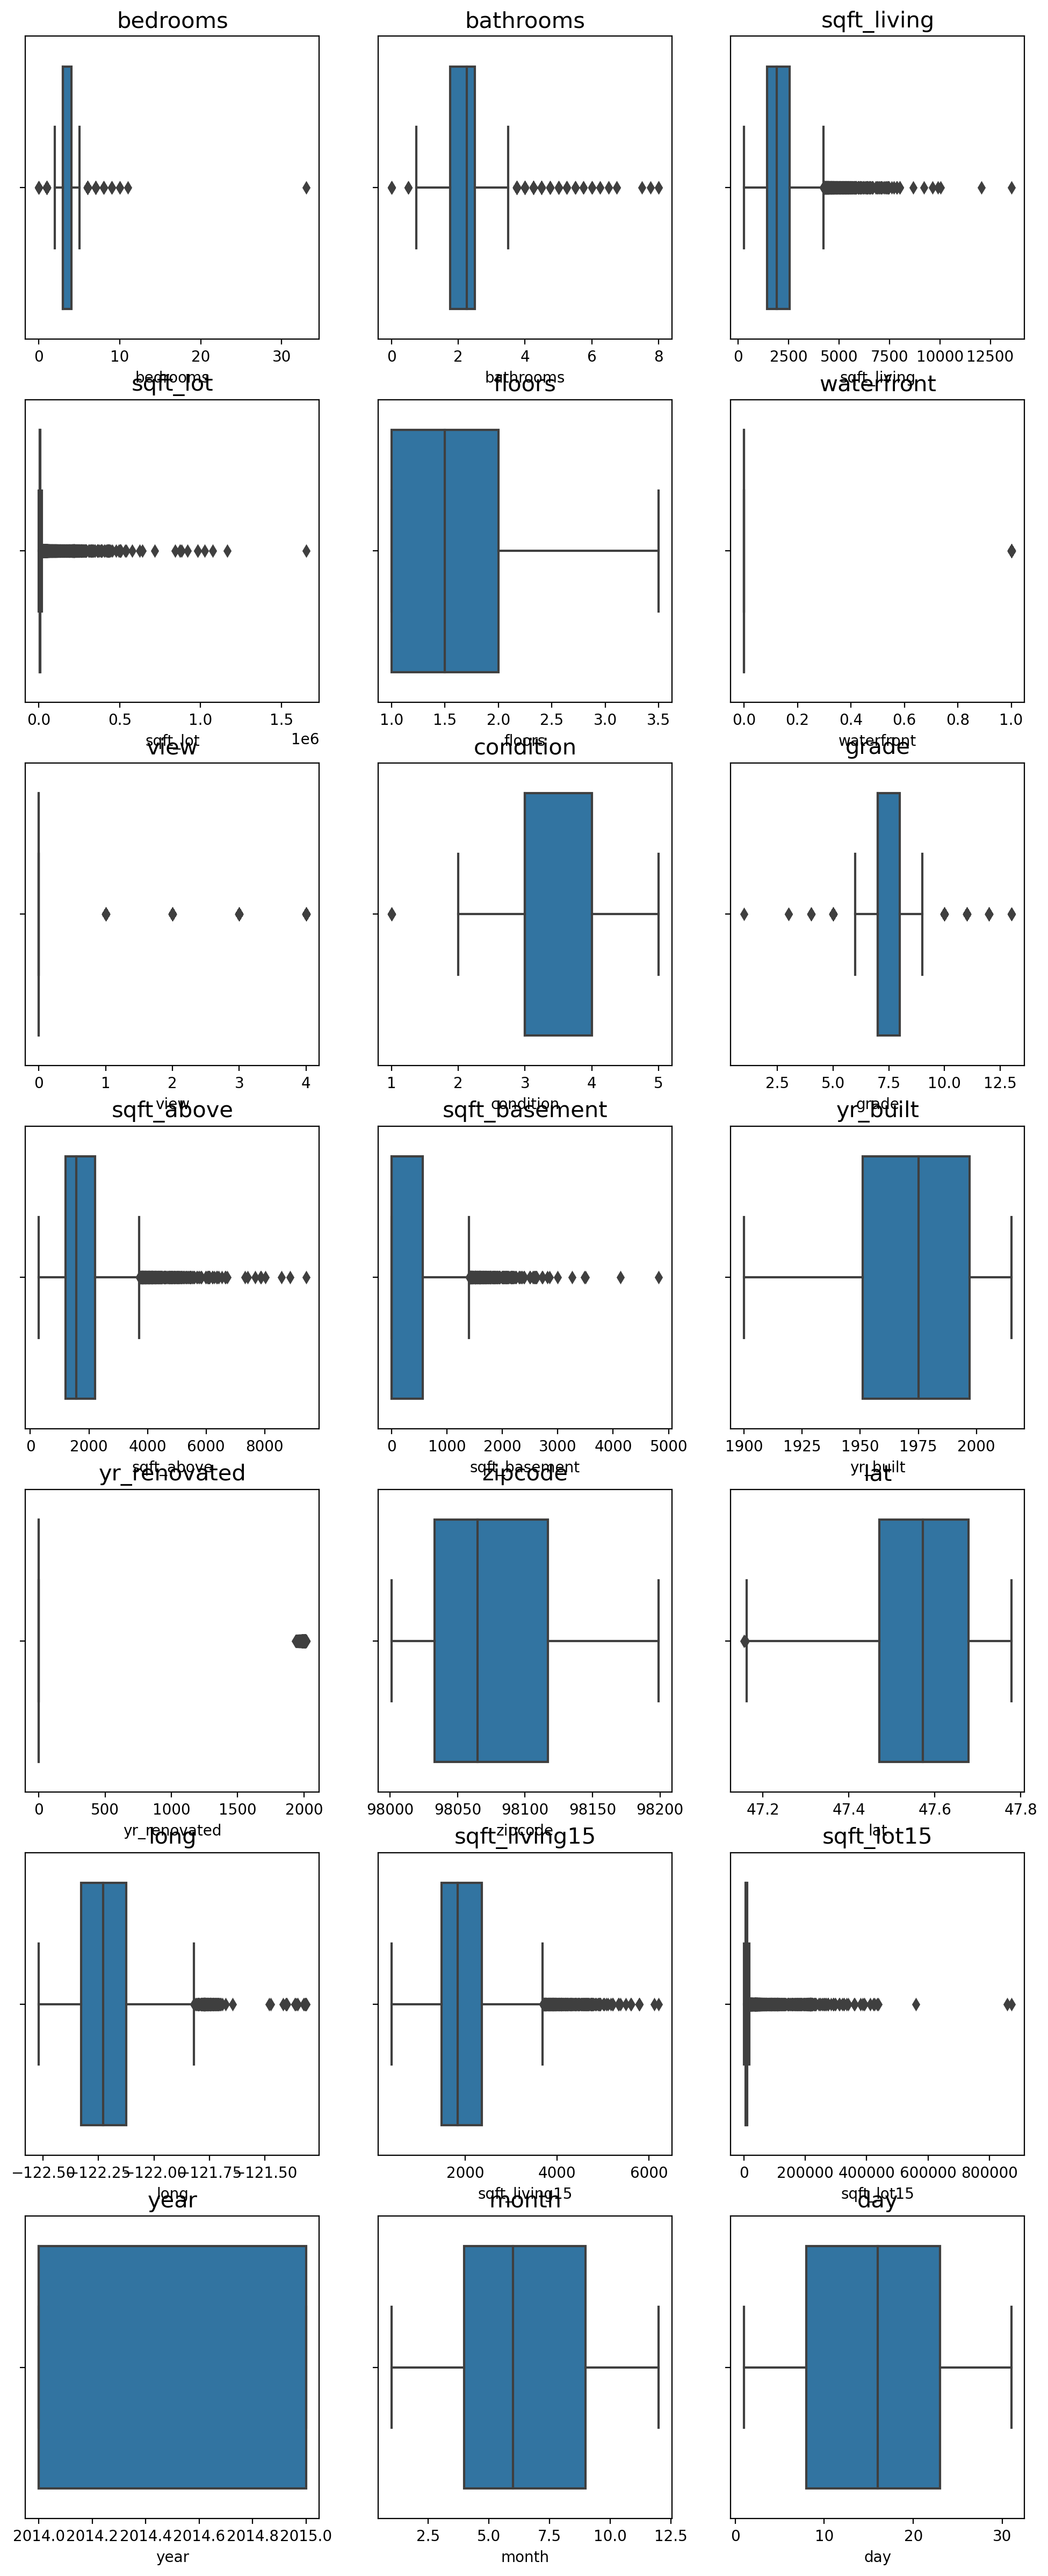

In [28]:
fig, ax = plt.subplots(7, 3, figsize=(12, 30))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
columns = whole_X.columns
count = 0
for row in range(7):
    for col in range(3):
        sns.boxplot(x=whole_X[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == whole_X.shape[1]:
            break
            
plt.show()

sqft_basement의 그래프 모양이 매우 이상하므로 조치를 취해야 한다.  
지하실 유무로 범주화시킨 basement_whether 특성을 생성하고  
sqft_basement와 sqft_above 특성값을 합친 sqft_aboveNbasement를 생성한 후  
sqft_basement와 sqft_above 특성을 삭제한다.

In [29]:
whole_X['basement_whether'] = whole_X['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
whole_X['basement_whether'].head()

0    0
1    0
2    0
3    0
4    0
Name: basement_whether, dtype: int64

In [30]:
whole_X['sqft_aboveNbasement'] = whole_X[['sqft_above', 'sqft_basement']].sum(axis=1)
print(whole_X['sqft_aboveNbasement'].head())

print(whole_X.shape)
whole_X.drop(['sqft_above', 'sqft_basement'], axis=1, inplace=True)
print(whole_X.shape)

0    1180
1     770
2    1680
3    1715
4    1060
Name: sqft_aboveNbasement, dtype: int64
(21503, 23)
(21503, 21)


yr_renovated 수치형 데이터지만 그래프는 마치 범주형 데이터처럼 생겨서 조치가 필요해 보인다.  
재건축 여부로 범주화시킨 renovated_whether 특성을 생성하고  
renovated_whether 특성을 삭제한다.

In [31]:
whole_X['renovated_whether'] = whole_X['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
print(whole_X['renovated_whether'].head())

print(whole_X.shape)
whole_X.drop('yr_renovated', axis=1, inplace=True)
print(whole_X.shape)

0    0
1    0
2    0
3    0
4    0
Name: renovated_whether, dtype: int64
(21503, 22)
(21503, 21)


## 3.4 치우쳐진 특성에 로그 씌우기!

한 쪽으로 치우쳐져 있는(왜도의 절대값이 큰) 특성들을 찾아서 log1p를 씌워준다.

In [32]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_aboveNbasement', 'sqft_lot15']

for column in skew_columns:
    whole_X[column] = np.log1p(whole_X[column].values)

## 3.5 범주형 특성에 원핫 인코딩하기!

In [33]:
whole_X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'month', 'day',
       'basement_whether', 'sqft_aboveNbasement', 'renovated_whether'],
      dtype='object')

In [34]:
whole_X = pd.get_dummies(whole_X, columns=['waterfront', 'view', 'condition', 'grade', 'yr_built', 'zipcode', 'year', 'month', 'day', 'basement_whether', 'renovated_whether'])

In [35]:
whole_X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,lat,long,sqft_living15,sqft_lot15,sqft_aboveNbasement,...,day_26,day_27,day_28,day_29,day_30,day_31,basement_whether_0,basement_whether_1,renovated_whether_0,renovated_whether_1
0,1.386294,1.00,7.074117,8.639588,1.0,47.5112,-122.257,1340,8.639588,7.074117,...,0,0,0,0,0,0,1,0,1,0
1,1.098612,1.00,6.647688,9.210440,1.0,47.7379,-122.233,2720,8.995041,6.647688,...,0,0,0,0,0,0,1,0,1,0
2,1.386294,2.00,7.427144,8.997271,1.0,47.6168,-122.045,1800,8.923191,7.427144,...,0,0,0,0,0,0,1,0,1,0
3,1.386294,2.25,7.447751,8.827615,2.0,47.3097,-122.327,2238,8.827615,7.447751,...,0,1,0,0,0,0,1,0,1,0
4,1.386294,1.50,6.966967,9.181118,1.0,47.4095,-122.315,1650,9.181118,6.966967,...,0,0,0,0,0,0,1,0,1,0


레이블에도 마찬가지도 로그 씌워주기!  
다만 나중에 레이블 예측값에는 expm1을 씌워서 값의 스케일을 원상복구 시켜야 한다!

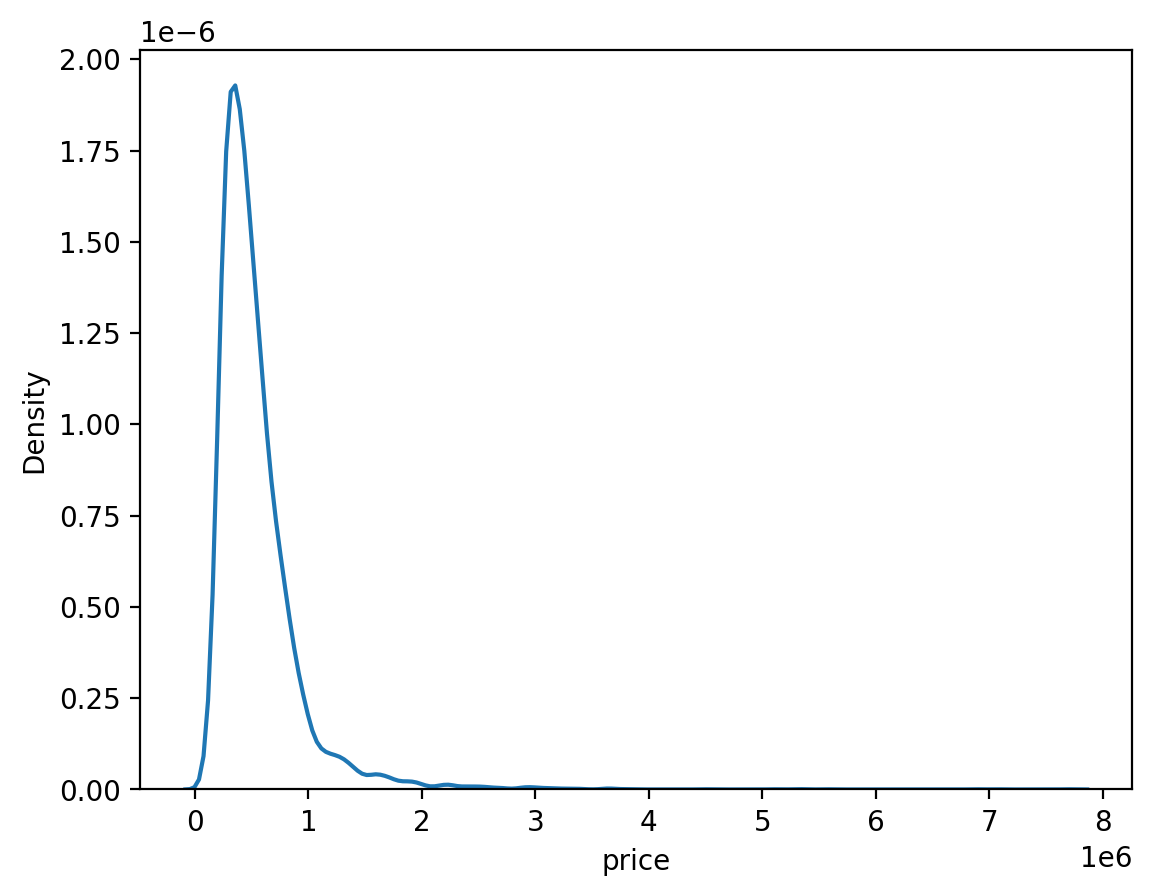

In [36]:
sns.kdeplot(train_y)
plt.show()

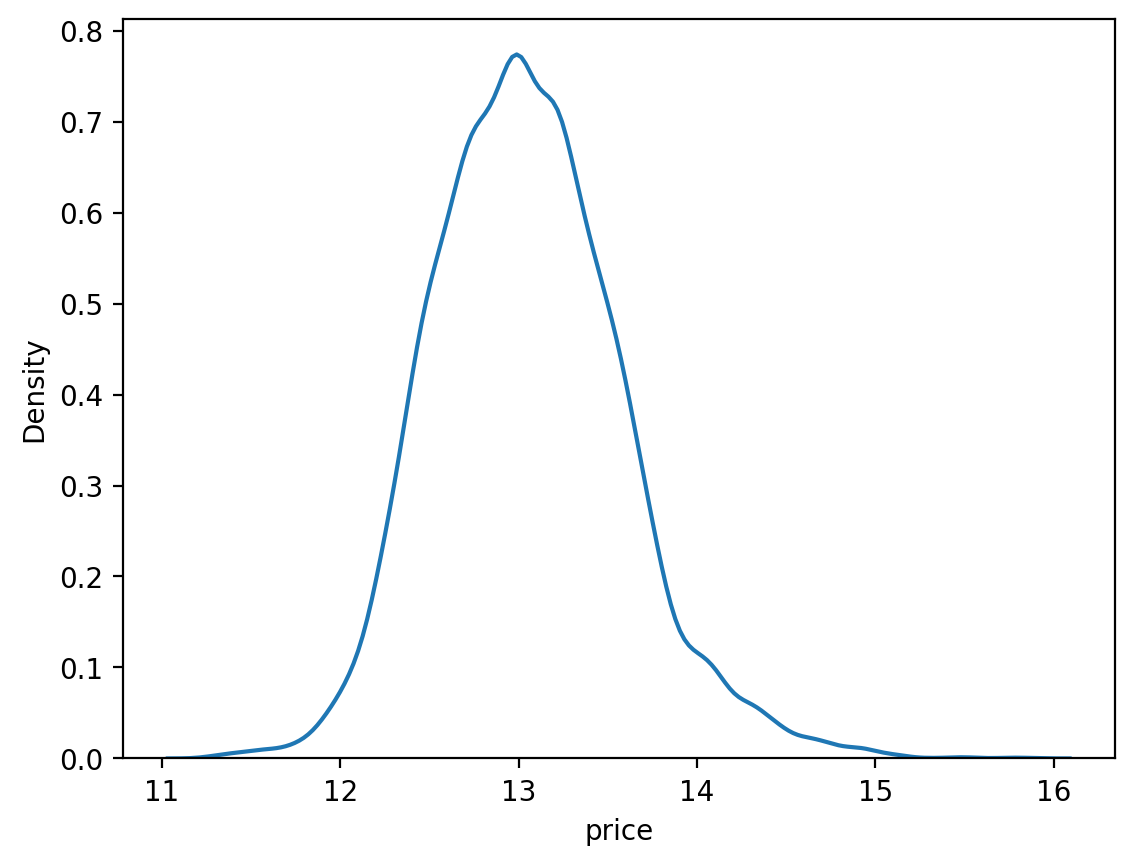

In [37]:
train_y = np.log1p(train_y)

sns.kdeplot(train_y)
plt.show()

## 3.6 train, test 다시 나누기!

In [38]:
train_X = whole_X.iloc[:len(train), :]
test_X = whole_X.iloc[len(train):, :]

print(train_X.shape)
print(test_X.shape)

(15035, 269)
(6468, 269)


# 4. 모델 파라미터 서치하기!

In [39]:
def tsize(train_X): # 지극히 주관적인 적당한 test size 값 찾는 함수
    length = len(train_X)
    return round(0.14 * (1 + length / 10 ** 4) ** (10 ** 4 / length) - 0.13, 2)

그리드 서치를 하고 데이터 프레임으로 평가 결과를 리턴해주는 함수를 생성한다.

In [40]:
def my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train_X, train_y)

    # 퍙기 결과 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 평가 결과를 담을 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-results['score'])
    results = results.sort_values('RMSLE')

    return results

In [41]:
random_state = 9

In [42]:
model = GradientBoostingRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [540, 550],
    'max_depth': [4, 5],
}

my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,5,550,-0.027565,0.166028
2,5,540,-0.027573,0.166051
1,4,550,-0.027816,0.166782
0,4,540,-0.027830,0.166822


In [43]:
model = XGBRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [1100, 1200],
    'max_depth': [2, 3],
}

my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\Hugh\anaconda3\envs\tensorflow\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,max_depth,n_estimators,score,RMSLE
0,2,1100,-0.027445,0.165667
1,2,1200,-0.027449,0.165677
2,3,1100,-0.028545,0.168953
3,3,1200,-0.028683,0.169360


In [44]:
model = LGBMRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [4910, 4920],
    'max_depth': [2, 3],
    'min_child_samples': [27, 28],
}

my_GridSearch(model, train_X, train_y, param_grid, verbose=2, n_jobs=7)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,max_depth,min_child_samples,n_estimators,score,RMSLE
3,2,28,4920,-0.026990,0.164288
2,2,28,4910,-0.026994,0.164297
1,2,27,4920,-0.027014,0.164361
0,2,27,4910,-0.027017,0.164368
6,3,28,4910,-0.027680,0.166374
7,3,28,4920,-0.027689,0.166399
4,3,27,4910,-0.027719,0.166490
5,3,27,4920,-0.027719,0.166492


In [45]:
def rmse(y_test, y_pred): # RMSE 손실 함수
    # 로그를 씌웠던 레이블에 다시 지수를 씌워서 스케일을 원상복구하고 평가하기
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

그리드 서치로 찾은 성능이 좋은 하이퍼 파라미터들을 적용시킨 모델들끼리로 또 비교 평가를 하는 함수를 생성한다.

In [46]:
def get_scores(models, train_X, train_y):
    scores = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=random_state, test_size=tsize(train_X))
        
        scaler = RobustScaler() # 표준화 스케일러
        X_train = scaler.fit_transform(X_train) # X_train 데이터를 fit과 동시에 transform
        X_test = scaler.transform(X_test) # X_test 데이터를 transform
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores[model_name] = rmse(y_test, y_pred) # 모델 별 RMSE 값 계산
        scores_df = pd.DataFrame(scores, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return scores_df

In [47]:
gboost = GradientBoostingRegressor(max_depth=5, n_estimators=550)
xgboost = XGBRegressor(max_depth=2, n_estimators=1100)
lightgbm = LGBMRegressor(max_depth=2, n_estimators=4910, min_child_samples=27)

models = [gboost, xgboost, lightgbm]

In [48]:
get_scores(models, train_X, train_y)

,RMSE
XGBRegressor,135629.453448
LGBMRegressor,125290.161477
GradientBoostingRegressor,117145.852550


# 5. 성능이 최고로 좋은 모델을 학습시키고 예측값 저장하기!

1. 모델을 학습시키고,  
2. 학습시킨 모델로 레이블을 예측하고,  
3. 예측값을 expm1로 스케일을 원상복구하고,  
4. 예측값을 csv로 저장  

해주는 함수를 생성한다.

In [52]:
def save_submission(last_model, train_X, train_y, test_X):
    model_name = last_model.__class__.__name__
    last_model.fit(train_X, train_y)
    test_y = last_model.predict(test_X)
    test_y = np.expm1(test_y) # 스케일 원상복구
    data_dir = os.getenv('USERPROFILE')+'\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\\3\data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = test_y
    submission_csv_path = '{}\submission_{}.csv'.format(data_dir, model_name)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [53]:
last_model = LGBMRegressor(max_depth=2, n_estimators=4910, min_child_samples=27)

In [54]:
save_submission(last_model, train_X, train_y, test_X)

C:\Users\Hugh\OneDrive - 수원대학교\Office\AIFFEL\Workspace\Exploration\3\data\submission_LGBMRegressor.csv saved!


# 6. 서브미션 점수 확인하기!

저장한 submission 파일을 캐글에 제출하고 점수를 확인한다.

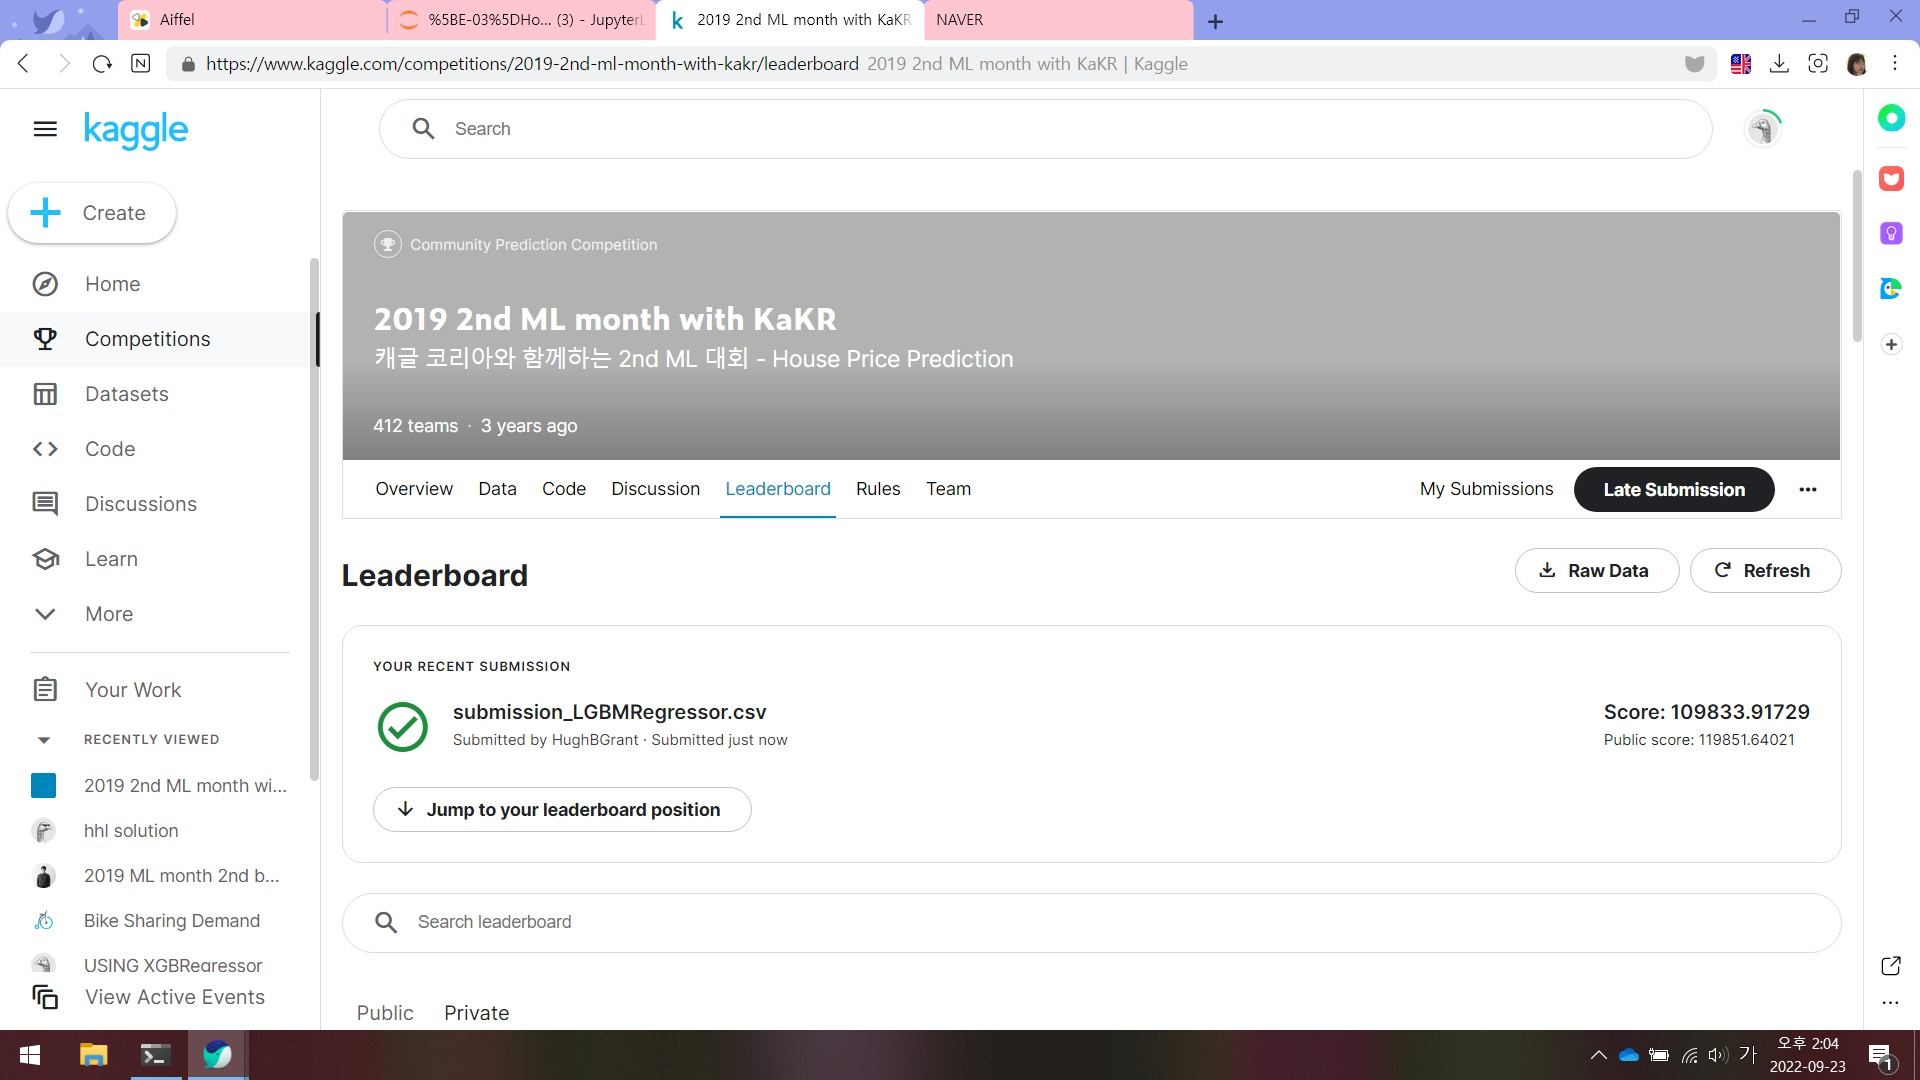

## 6.1 이번 프로젝트에서 어려웠던 점

이번 데이터에서는 전처리해야 할 것들이 많아서 시각화를 해서 각 특성에 처리해야 할 조치를  
스스로 찾아내고 고쳐야 하는 점이 어려웠다.  
또한 루브릭 평가 점수를 맞추는 것이 어려웠는데,  
그리드 서치, 모델 평가에 시간도 많이 들어서 밤을 새우며 코드를 돌린 점이 힘들었다. 

## 6.2 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

전처리와 피처 엔지니어링을 열심히 해도 점수가 낮을 수도 있다는 사실을 알아냈다.  
전처리와 피처 엔지니어링에 모델 파라미터보다 많은 시간을 들였지만 막상 보니  
그리드 서치가 점수를 더 나왔다.  
또한 하다보니 시간이 부족했는데 앞부분에 너무 힘을 쏟아붇지 않고  
우선적으로 간단하게 코드를 작성하고 시간이 남으면 살을 더 붙이는 방식으로  
프로젝트는 진행해야 시간이 안부족할 것이라는 점을 깨달았다.

그리고 모호한 점도 있었는데 train, test 데이터 셋을 합쳐서  
전체 데이터 셋으로 시각화를 하기도 하는데  
test 데이터 셋을 섞어서 데이터 분포를 확인해도 되는지 이론적으로 의문지 들기도 했다.

## 6.3 루브릭 평가 지표를 맞추기 위해 시도한 것들

전처리
1. 필요 없는 특성 제거  
2. 시계열 년월일로 분리
3. 범주형인데 수치형 분포를 보이거나 수치형인데 분포를 보이거나 기타 등등 이상한 분포를 보이는 특성들을  
범주형으로 바꾸거나 합치는 등 조치  
4. 한쪽으로 치우쳐진 분포를 가진 수치형 특성 log1p 적용
5. 범주형 특성 원핫 인코딩
6. 레이블도 한쪽으로 치우쳐진 분포라면 log1p 적용  
(다만 손실함수를 계산할 때나 최종 예측값을 계산할 때 expm1로 스케일 원상복구)

모델링
1. 그리드 서치
2. 캐글에 여러번 제출해서 평가

## 6.4 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

다행히도 마지막 날 RMSE 110000 이하를 달성했다. 모델링에 시간을 많이 투자해야 점수가 잘나온다.

## 6.5 자기 다짐

왜 프로그래밍 관련 직종이 밤샘 작업이 심하다고 소문 났는지 알 것 같은 프로젝트였다.  
하지만 가면 갈수록 이것보다 더 빡센 프로젝트들이 기다리고 있다고 생각하니 걱정 반 설렘 반이었다.  
피곤하긴 하지만 점수가 점점 나아지는 것을 보니까 재미도 있었다.  내 적성에 잘 맞는 것 같다.
눈꺼풀이 감기며 비몽사몽 작업하는 시간이 싫으면서도 동시에 살아있음을 느끼게 해주었다.  

이제 어느 정도 분석 기술을 배웠으니 분석보다는  
인문적으로 분석 절차에 대한 템플릿을 만들기, 프로젝트의 목표 설정 및 문제 정의 등  
다른 사람과의 소통에 도움되는 것들에 좀 더 치중해야겠다는 생각을 했다.